In [1]:
from transformers import BertForMaskedLM, BertTokenizer
import torch
import polyglot
from polyglot.text import Text, Word
from word2word import Word2word
from embedding_transform import EmbeddingTransform

import matplotlib.pyplot as plt

import argparse
import os
import pickle
import numpy as np
from tqdm import tqdm
from collections import Counter
import json
# import nltk

#DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = "cpu"

In [2]:
nl2en = Word2word("nl", "en")

In [3]:
with open('data/filtered_en_nl_dict.txt', 'r', encoding="utf-8") as f:
    lines = f.read().splitlines()
    en_words_to_embed = [words.split('\t')[1] for words in lines]
    nl_words_to_embed = [words.split('\t')[0] for words in lines]

save_fn = "./models/stored_embeddings-all.pkl"    
with open(save_fn, "rb") as f:
    fc = pickle.load(f)
    english_embeddings = fc["eng_emb"]
    dutch_embeddings = fc["dut_emb"]
    
split = int(len(dutch_embeddings)*0.8)

train_src_embeds = torch.tensor(dutch_embeddings[:split], requires_grad=False, device=DEVICE)
train_trg_embeds = torch.tensor(english_embeddings[:split], requires_grad=False, device=DEVICE)
train_src_words = nl_words_to_embed[:split]
train_trg_words = en_words_to_embed[:split]

test_src_embeds = torch.tensor(dutch_embeddings[split:], requires_grad=False, device=DEVICE)
test_trg_embeds = torch.tensor(english_embeddings[split:], requires_grad=False, device=DEVICE)
test_src_words = nl_words_to_embed[split:]
test_trg_words = en_words_to_embed[split:]

d:\david\miniconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
d:\david\miniconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
d:\david\miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
d:\david\miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTe

In [4]:
def calculate_prediction_acc(transform, source_embeds, target_embeds):
    correct_words = 0
    
    sims = torch.cdist(source_embeds @ transform, target_embeds)
    
    best_sims = torch.argmin(sims, dim=1)
    
    for src_idx, trg_idx in enumerate(best_sims):
        if src_idx == trg_idx:
            correct_words += 1

    return correct_words / len(source_embeds)


In [5]:
transform = torch.zeros((256, 768), requires_grad=True, device=DEVICE)
torch.nn.init.xavier_uniform_(transform)
optim = torch.optim.Adam((transform,), lr=0.001)
loss_fn = torch.nn.MSELoss().to(DEVICE)

targets = train_trg_embeds.clone().to(DEVICE)
samples = train_src_embeds.clone().to(DEVICE)

batch_size = 32

losses = []
train_accs = []
test_accs = []

for ep in range(1000):

    shf = torch.randperm(samples.shape[0])

    samples = samples[shf]
    targets = targets[shf]

    tot_loss = 0
    for b_start in range(0, samples.shape[0], batch_size):

        optim.zero_grad()

        batch_inputs = samples[b_start:b_start+batch_size, :].clone().detach()
        batch_targets = targets[b_start:b_start+batch_size, :].clone().detach()

        batch_outputs = batch_inputs @ transform

        loss = loss_fn(batch_outputs, batch_targets)
        loss.backward()
        optim.step()

        tot_loss += loss.item()

    losses.append(tot_loss)

    if len(losses) > 10 and np.mean(losses[-10:]) < np.mean(losses[-4:]):
        print("early stopping condition reached")
        break
    
    #print(f"epoch: {ep} loss: {tot_loss}")
    train_acc = calculate_prediction_acc(transform, train_src_embeds, train_trg_embeds)
    test_acc = calculate_prediction_acc(transform, test_src_embeds, test_trg_embeds)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    #print(f"train accuracy: {train_acc} test accuracy: {test_acc}")



early stopping condition reached


In [6]:
XX = train_src_embeds.T @ train_trg_embeds
XX_ = train_trg_embeds.T @ train_src_embeds
U, _, V = torch.svd(XX)
U_, _, V_ = torch.svd(XX_)

transform = V_ @ U_.T

tra_acc_svd = calculate_prediction_acc(transform, train_src_embeds, train_trg_embeds)
val_acc_svd = calculate_prediction_acc(transform, test_src_embeds, test_trg_embeds)

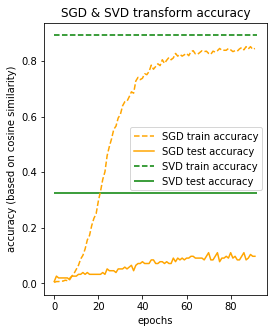

In [29]:
plt.rcParams["figure.figsize"] = (4, 5)

sgdcolor = 'orange'
svdcolor = 'green'

plt.plot(train_accs, '--', label="SGD train accuracy", color=sgdcolor)
plt.plot(test_accs, label="SGD test accuracy", color=sgdcolor)
plt.hlines(tra_acc_svd, 0, len(train_accs), linestyles='--', label="SVD train accuracy", color=svdcolor)
plt.hlines(val_acc_svd, 0, len(train_accs), label="SVD test accuracy", color=svdcolor)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("accuracy (based on cosine similarity)")
plt.title("SGD & SVD transform accuracy")
plt.savefig("./figures/transform_accuracy.png", bbox_inches='tight')
plt.show()

0.8926829268292683
0.3246753246753247
